# Primerjava pristopov za luščenje ključnih fraz na povzetkih člankov s ključno besedo "Longevity"

V tem zvezku predstavljamo primerjavo pristopov za luščenje ključnih besed iz nabora povzetkov člankov s ključno besedo "Longevity" v zbirki PubMed.

Predstavili bomo objektivno primerjavo pristopov za luščenje besed. Primerjali bomo izluščene besede s ključnimi besedami, ki so jih označili avtorji člankov. Za vsako metodo bomo prikazali povprečno preciznost (precision), priklic (recall) in mero F1.

In [1]:
import string
import ast

import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import yake
import rake
from operator import is_not
from functools import partial

from textsemantics import specific_words
from utils.scores import (
    precision, recall, average_precision, average_recall, average_f_score,
    take_n, score_in_len_range
)
from bert_keyword_extractor import TransformerKeywordExtractor

# max len of keyphrase
N_GRAM_LEN = 3

Naložimo metapodatke in dokumente iz zbirke in dokumente preprocesiramo in izluščimo posamezne besede.

In [2]:
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        # lematizer in rare cases produce empty strings - removing them
        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed

df = pd.read_pickle("data/pubmed_longevity.pkl")
len_before = len(df)

# izpusti članke brez ključnih besed - izbriši None vrednosti v senznamu ključnih besed
# po brisanju None vrednosti nekatera besedila izgubijo ključne besede, odstrani jih
df = df[~df["keywords"].isnull()]
df["keywords"] = df["keywords"].apply(lambda x: [k for k in x if k is not None])
# izputsti kljucne besede z vec kot N_GRAM_LEN besedami
# e.g. if N_GRAM_LEN == 3 we skip just 2% words
df["keywords"] = df["keywords"].apply(lambda x: [k for k in x if len(k.split()) <= N_GRAM_LEN])
df = df[df["keywords"].apply(len) != 0]

# some keywords were not splited on seperate keyword by PubMed so keyword is comma separaed string
# of keywords, others have coma which is part of the keyword. It is hard to distinguish both
# so we are dropping 92 
print("Z vejicami", len(df))
df = df[~df["keywords"].apply(lambda x: any(", " in k for k in x))]
print("Brez vejic", len(df))

# izpusti prazne abstracte
df = df[df["abstract"].str.len() >= 100]

tokens_list = preprocess(df["abstract"])

print(f"Število dokumentov: {len(df)}/{len_before}")

Z vejicami 4582
Brez vejic 4509
Število dokumentov: 4508/16791


Poglejmo si podatkte in izseke prvih 5 dokumentov

In [3]:
df.head()

,title,abstract,journal,authors,mesh_terms,keywords,pubmed_id,year
0,The practice of self-preserving behavior of th...,One of world trends in health care social poli...,"Problemy sotsial'noi gigieny, zdravookhranenii...","[T K Rostovskaya, A K Ivanova, E A Kniazkova]","[Delivery of Health Care, Demography, Health P...","[demographic behavior, health, longevity, self...",33591658,2021
2,Consumption of field-realistic doses of a wide...,Commercial beekeepers in many locations are ex...,"Environmental pollution (Barking, Essex : 1987)","[Jordan R Glass, Adrian Fisher, Jennifer H Few...","[Animals, Bees, Digestion, Fungicides, Industr...","[Flight metabolic rate, Flight performance, Fu...",33529906,2021
7,Casein-maltodextrin Maillard conjugates encaps...,Practical application of proanthocyanidins (PA...,Food chemistry,"[Xianbao Sun, Xuejiao Wu, Xiangyu Chen, Rui Gu...","[Animals, Antioxidants, Caenorhabditis elegans...","[Antioxidant activity, Bioaccessibility, Casei...",33421900,2020
8,Aging and Senescence across Reproductive Trait...,AbstractWhy do senescence rates of fitness-rel...,The American naturalist,"[Eve B Cooper, Timothée Bonnet, Helen L Osmond...","[Aging, Animals, Australian Capital Territory,...","[Malurus, aging, extrapair paternity, life-his...",33417527,2020
10,Lead stress affects the reproduction of Spodop...,Lead (Pb) stress affects hormone-mediated resp...,Ecotoxicology and environmental safety,"[Jialiang Zhou, Jin Chen, Yinghua Shu]","[Animals, Diet, Environmental Pollutants, Fema...","[Heavy metal stress, Insect reproduction, Mult...",33396104,2020


Sedaj bomo pridobili ključne besede z vsako od primerjanih metod:
- [TF-IDF](https://github.com/biolab/text-semantics/blob/main/examples/04_03_specific_words_with_tfidf.ipynb)
- [Metoda z vložitvami:](https://github.com/biolab/text-semantics/blob/main/examples/04_01_specific_words_with_embeddings.ipynb) samo na besedah v dokumentih
- [RAKE](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [Yake!](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)

In [4]:
%%time 
def tfidf_keywords(tokens):
    joined_texts = [" ".join(tokens) for tokens in tokens]
    vectorizer = TfidfVectorizer(ngram_range=(1, N_GRAM_LEN))
    X = vectorizer.fit_transform(joined_texts)
    words = vectorizer.get_feature_names()

    keywords = []
    for row in X:
        features = [(words[i], row[0, i]) for i in row.nonzero()[1]]
        keywords.append(sorted(features, key=lambda tup: tup[1], reverse=True))
    return keywords


tfidf_keywords = tfidf_keywords(tokens_list)
tfidf_keywords = [[x for x, _ in wds] for wds in tfidf_keywords]

/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 52.4 s, sys: 646 ms, total: 53.1 s
Wall time: 53.1 s


In [5]:
%%time 
stop_path = "utils/english-stopwords.txt"
rake_object = rake.Rake(stop_path, max_words_length=3)
def rake_method(text):    
    kw = rake_object.run(text)
    # rake works on unormalized texts so normalize them afterwards
    return [" ".join(lemmatizer.lemmatize(w) for w in x.split()) for x, _ in kw if x not in stop_words]

rake_keywords = [rake_method(txt) for txt in df["abstract"]]

CPU times: user 11.6 s, sys: 6.93 ms, total: 11.6 s
Wall time: 11.6 s


In [6]:
%%time 
custom_kw_extractor = yake.KeywordExtractor(lan="en", n=3, top=20)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [" ".join(lemmatizer.lemmatize(w) for w in x.split()) for x, _ in kw]

yake_keywords = [yake_method(txt) for txt in df["abstract"]]

CPU times: user 8min 6s, sys: 92.3 ms, total: 8min 7s
Wall time: 8min 6s


In [7]:
%%time
import spacy
import pytextrank

def text_rank(texts):
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe("textrank")
    
    def text_rank(text):
        doc = nlp(text)
        return [" ".join(lemmatizer.lemmatize(w) for w in x.text.split()) 
                for x in doc._.phrases if len(x.text.split()) <= N_GRAM_LEN]

    return [text_rank(t) for t in texts]

text_rank_keywords = text_rank(df["abstract"])

CPU times: user 3min 58s, sys: 494 ms, total: 3min 59s
Wall time: 3min 59s


In [8]:
%%time

def get_kws(model_path):
    extractor = TransformerKeywordExtractor(model_path)
    bert_keywords = extractor.extract_keywords(df['abstract'])
    del extractor
    return [[w for w, _ in kws] for kws in bert_keywords]
        
crosloengual_keywords = get_kws('models/crosloeng')
mbert_keywords = get_kws('models/mbert')

  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 4917
  Batch size = 8


/home/primoz/text-semantics/examples/bert_keyword_extractor.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(predictions).to(self.device), dim=2)
loading configuration file models/mbert/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": "ner",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B",
    "1": "I",
    "2": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B": 0,
    "I": 1,
    "O": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 4762
  Batch size = 8


CPU times: user 3min 1s, sys: 2min 36s, total: 5min 38s
Wall time: 5min 15s


In [9]:
methods = [
    # ("Emb - document", emb_doc_keywords),
    ("TFIDF", tfidf_keywords),
    ("RAKE", rake_keywords),
    ("YAKE", yake_keywords),
    ("TextRank", text_rank_keywords),
    ("mBert", mbert_keywords),
    ("CroSloEngual", crosloengual_keywords),
]

Ko imamo pridobljene ključne besede, si izpišemo povprečno število ključnih besed in najmanjše število ključnih besed, ki jih vsaka od metod vrne. Te statitike nam služijo zgolj, da vidimo ali je bila izluščitev besed uspešna. Nekatere metode omogočajo nastavljanje števila najbolj pomembnih ključnih besed zato imamo tam tipično manj ključnih besed na besedilo.

In [10]:
for name, kw in methods:
    print(
        f"{name} - Povprečno število besed:", 
        f"{sum(len(x) for x in kw) / len(kw):.1f}",
        "Minimalno število specifičnih besed:",
        min(len(x) for x in kw)
    )

TFIDF - Povprečno število besed: 317.3 Minimalno število specifičnih besed: 33
RAKE - Povprečno število besed: 59.8 Minimalno število specifičnih besed: 4
YAKE - Povprečno število besed: 20.0 Minimalno število specifičnih besed: 20
TextRank - Povprečno število besed: 51.8 Minimalno število specifičnih besed: 5
mBert - Povprečno število besed: 1.9 Minimalno število specifičnih besed: 0
CroSloEngual - Povprečno število besed: 2.2 Minimalno število specifičnih besed: 0


Izračunajmo natančnosti s pripravljenimi merami in jih izrišimo. Izračunamo povprečno preciznost, priklic in mero F1 za različno število izbranih najbolj pomembnih ključnih besed. Z vsako metodo smo pridobili seznam ključnih besed, ki je razvrščen po pomembnosti. Za namen izrisa grafov smo se odločili, da izračunamo vse tri mere za število ključnih besed v intervalu med 1 in 20. Na ta način vidimo kako uspešna je metoda glede na izbrano število ključnih besed.

Izrišemo po en graf za vsako od mer - graf, ki prikazuje vrednost mere v odvisnosti od števila izbranih najboljših ključnih besed. Četrti graf prikazuje preciznost in priklic na enem grafu. V tem grafu ima metoda krivuljo iz večih točk. Vsaka od točk predstavlja preciznost in priklic za različno število izbranih ključnih besede. Metoda katere krivulja je bližje zgornjemu desnemu kotu, je boljša. 


In [11]:
kw = df['keywords'].tolist()
kw = [[" ".join(lemmatizer.lemmatize(x) for x in t.lower().split()) for t in k] for k in kw]

assert len(kw) == len(df)

precisions = [score_in_len_range(pred, kw, average_precision) for _, pred in methods]
recalls = [score_in_len_range(pred, kw, average_recall)  for _, pred in methods]
f_scores = [score_in_len_range(pred, kw, average_f_score)  for _, pred in methods]

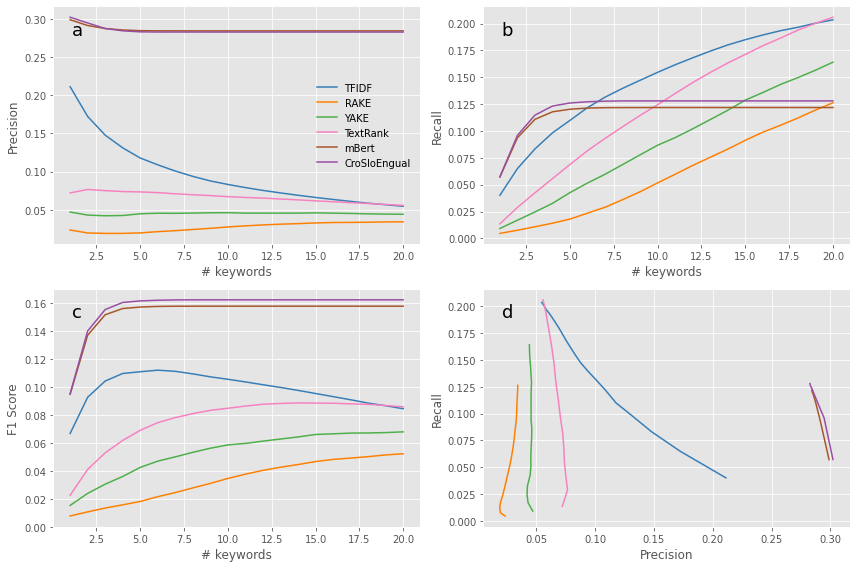

In [12]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

plt.style.use('ggplot')
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')

scores = (
    ("Precision", precisions),
    ("Recall", recalls),
    ("F1 Score", f_scores),
)
labels = ["a", "b", "c"]
for i, (title, sc) in enumerate(scores):
    ax1 = plt.subplot(2, 2, i + 1)
    for p, (l, _), c in zip(sc, methods, CB_color_cycle):
        plt.plot(range(1, 21), p, label=l, color=c)
    if i == 0:
        l = plt.legend()
        l.get_frame().set_linewidth(0.0)
        l.get_frame().set_facecolor('none')
    plt.xlabel("# keywords")
    plt.ylabel(title)
    ax1.text(0.05, 0.88, labels[i], transform=ax1.transAxes, fontsize=18)
        
ax1 = plt.subplot(2, 2, 4)
for p, r, (l, _), c in zip(precisions, recalls, methods, CB_color_cycle):
    plt.plot(p, r, label=l, color=c)
plt.xlabel("Precision")
plt.ylabel("Recall")
ax1.text(0.05, 0.88, "d", transform=ax1.transAxes, fontsize=18)
# plt.suptitle("Keyphrases")

plt.tight_layout()
plt.savefig("keyphrase-comparison.eps")

In [13]:
def mrr(pred, true_keywords):   
    def first_idx(p, kw):
        return next((p.index(el) + 1 for el in p if el in kw), None)
    ranks = [first_idx(pr, k) for pr, k in zip(pred, true_keywords)]
    return sum(1/r if r is not None else 0 for r in ranks)/len(ranks)

def take_same_number(pred, true):
    return [p[:len(t)] for p, t in zip(pred, true)]

def score_same_len(predictions, keywords, score_method):
    return score_method(take_same_number(predictions, keywords), keywords)

def map_(predictions, keywords):
    # http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html
    def ap(pred, kws):
        appearances = [1 if p in kws else 0 for p in pred]
        p_k = [sum(appearances[:i+1])/(i+1) for i, a in enumerate(appearances) if a > 0]
        return sum(p_k) / len(kws)
    
    return sum(ap(p, k) for p, k in zip(predictions, keywords)) / len(predictions)

In [14]:
precisions_same_number_keywords = [score_same_len(pred, kw, average_precision) for _, pred in methods]
recall_same_number_keywords = [score_same_len(pred, kw, average_recall) for _, pred in methods]
f1_same_number_keywords = [score_same_len(pred, kw, average_f_score) for _, pred in methods]
mmrrs = [mrr(pred, kw) for _, pred in methods]
maps = [map_(pred, kw) for _, pred in methods]

In [15]:
df_res = pd.DataFrame({
    "Precission": precisions_same_number_keywords,
    "Recall": recall_same_number_keywords,
    "F1": f1_same_number_keywords,
    "MRR": mmrrs,
    "MAP": maps,
}, index=[n for n, _ in methods])

df_res.style.bar(color='#d65f5f', vmin=0)

,Precission,Recall,F1,MRR,MAP
TFIDF,0.112587,0.112587,0.112587,0.326096,0.095463
RAKE,0.021572,0.021496,0.021529,0.091389,0.036933
YAKE,0.045335,0.045076,0.045181,0.132007,0.036796
TextRank,0.071524,0.071456,0.071486,0.191373,0.060793
mBert,0.284268,0.119284,0.156676,0.368185,0.098435
CroSloEngual,0.283321,0.125186,0.161507,0.381165,0.101266


## Histogrami

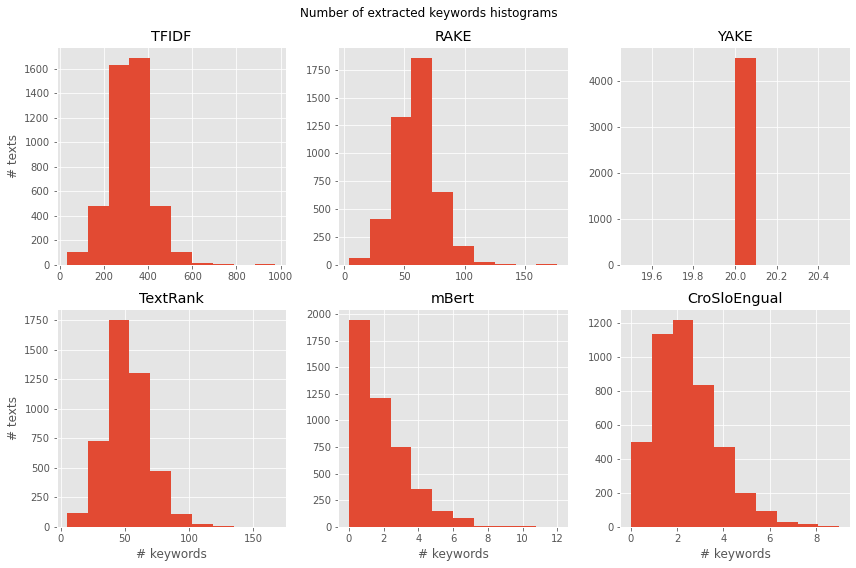

In [16]:
fig = plt.figure(figsize=(12,8))

for i, (m, kw) in enumerate(methods):
    plt.subplot(2, 3, i + 1)
    plt.hist([len(k) for k in kw])
    plt.title(m)
    if i in [3, 4, 5]:
        plt.xlabel("# keywords")
    if i in [0, 3]:
        plt.ylabel("# texts")
    
plt.suptitle("Number of extracted keywords histograms")
plt.tight_layout()
plt.savefig("num-extracted-words.eps")

## Besedila in ključne besede

In [17]:
import random
from random import randint
from IPython.display import display, Markdown

md = ""
random.seed(30)
random_texts = [randint(0, len(df)) + 1 for i in range(10)]
for i in random_texts:
    md += f"## {df['title'].iloc[i]}\n\n"
    md += df['abstract'].iloc[i] + "\n\n"
    md += f"**Keywords by author**: {', '.join(df['keywords'].iloc[i])}\n\n"
    for m, kw in methods:
        md += f"**{m}**: {', '.join(kw[i][:10])}\n\n"
        

display(Markdown(md))

## On mortality in the Czech Republic

"In this article, Czech mortality rates are inspected in a new perspective...the levels of mortality constructed in Coale's and Demeny's Regional Model Life Tables and in Coale's and Guang Guo's revised edition of the life tables.  Czech male and female life expectancies are also contrasted with hypothetical ones computed by means of Coale's equation which sets a 'standard' pattern of life expectancy development in low mortality societies." The impact of past political and social systems is also considered. (SUMMARY IN ENG AND RUS)

**Keywords by author**: Czech Republic, Czechoslovakia, Demographic Analysis, Demographic Factors, Developed Countries, Eastern Europe, Europe, Evaluation, Length Of Life, Life Expectancy, Life Table Method, Life Tables, Mortality, Population, Population Characteristics, Population Dynamics, Research Methodology, Sex Factors

**TFIDF**: coale, czech, life table, table, system also consider, social system also, political social system, past political social, impact past political, society impact past

**RAKE**: hypothetical one compute, female life expectancy, life expectancy development, low mortality society, czech mortality rate, mortality construct, life table, czech male, new perspective, guang guo

**YAKE**: Demeny Regional Model, Guang Guo revise, Regional Model Life, Model Life Table, Guo revise edition, Demeny Regional, Regional Model, Guang Guo, Czech mortality rate, Life Table

**TextRank**: life expectancy development, low mortality society, Coale, Czech mortality rate, mortality, revise edition, Guang Guo, hypothetical one, mean, Demeny

**mBert**: 

**CroSloEngual**: 

## The frailty index outperforms DNA methylation age and its derivatives as an indicator of biological age.

The measurement of biological age as opposed to chronological age is important to allow the study of factors that are responsible for the heterogeneity in the decline in health and function ability among individuals during aging. Various measures of biological aging have been proposed. Frailty indices based on health deficits in diverse body systems have been well studied, and we have documented the use of a frailty index (FI34) composed of 34 health items, for measuring biological age. A different approach is based on leukocyte DNA methylation. It has been termed DNA methylation age, and derivatives of this metric called age acceleration difference and age acceleration residual have also been employed. Any useful measure of biological age must predict survival better than chronological age does. Meta-analyses indicate that age acceleration difference and age acceleration residual are significant predictors of mortality, qualifying them as indicators of biological age. In this article, we compared the measures based on DNA methylation with FI34. Using a well-studied cohort, we assessed the efficiency of these measures side by side in predicting mortality. In the presence of chronological age as a covariate, FI34 was a significant predictor of mortality, whereas none of the DNA methylation age-based metrics were. The outperformance of FI34 over DNA methylation age measures was apparent when FI34 and each of the DNA methylation age measures were used together as explanatory variables, along with chronological age: FI34 remained significant but the DNA methylation measures did not. These results indicate that FI34 is a robust predictor of biological age, while these DNA methylation measures are largely a statistical reflection of the passage of chronological time.

**Keywords by author**: Aging, Biological age, DNA methylation, Frailty, Mortality

**TFIDF**: fi34, dna methylation, methylation, biological age, dna, age, age acceleration, measure, chronological, acceleration

**RAKE**: diverse body system, leukocyte dna methylation, age acceleration residual, age acceleration difference, dna methylation age, dna methylation measure, measure biological age, frailty index base, fi34 remain significant, dna methylation

**YAKE**: DNA methylation, DNA methylation age, age, biological age, DNA, DNA methylation measure, methylation, age acceleration, methylation age, biological

**TextRank**: DNA methylation age, chronological age, biological age, age acceleration residual, age acceleration difference, DNA methylation, leukocyte DNA methylation, biological age, chronological time, significant predictor

**mBert**: dna methylation, frailty index, age acceleration, dna methylation age

**CroSloEngual**: biological age, chronological age, dna methylation, frailty

## Metabolites Produced by the Oral Commensal Bacterium Corynebacterium durum Extend the Lifespan of Caenorhabditis elegans via SIR-2.1 Overexpression.

Human microbiota is heavily involved in host health, including the aging process. Based on the hypothesis that the human microbiota manipulates host aging via the production of chemical messengers, lifespan-extending activities of the metabolites produced by the oral commensal bacterium Corynebacterium durum and derivatives thereof were evaluated using the model organism Caenorhabditis elegans. Chemical investigation of the acetone extract of a C. durum culture led to the identification of monoamines and N-acetyl monoamines as major metabolites. Phenethylamine and N-acetylphenethylamine induced a potent and dose-dependent increase of the C. elegans lifespan, up to 21.6% and 19.9%, respectively. A mechanistic study revealed that the induction of SIR-2.1, a highly conserved protein associated with the regulation of lifespan, was responsible for the observed increased longevity.

**Keywords by author**: Caenorhabditis elegans, Corynebacterium durum, N-acetylphenethylamine, SIR-2.1, human microbiota, lifespan-extending activities, phenethylamine

**TFIDF**: monoamine, durum, human microbiota, microbiota, metabolite, chemical, observe increase longevity, responsible observe increase, lifespan responsible observe, regulation lifespan responsible

**RAKE**: durum culture led, mechanistic study reveal, observe increase longevity, human microbiota, heavily involve, host health, age process, chemical messenger, extend activity, metabolite produce

**YAKE**: human microbiota manipulate, microbiota manipulate host, manipulate host age, Human microbiota, heavily involve, bacterium Corynebacterium durum, host health, age process, organism Caenorhabditis elegan, commensal bacterium Corynebacterium

**TextRank**: 19.9%, 21.6%, major metabolite, monoamine, Corynebacterium, Caenorhabditis, lifespan, derivative, chemical messenger, C.

**mBert**: c. elegans, corynebacterium

**CroSloEngual**: caenorhabditis elegans

## Increasing autophagy and blocking Nrf2 suppress laminopathy-induced age-dependent cardiac dysfunction and shortened lifespan.

Mutations in the human LMNA gene cause a collection of diseases known as laminopathies. These include myocardial diseases that exhibit age-dependent penetrance of dysrhythmias and heart failure. The LMNA gene encodes A-type lamins, intermediate filaments that support nuclear structure and organize the genome. Mechanisms by which mutant lamins cause age-dependent heart defects are not well understood. To address this issue, we modeled human disease-causing mutations in the Drosophila melanogaster Lamin C gene and expressed mutant Lamin C exclusively in the heart. This resulted in progressive cardiac dysfunction, loss of adipose tissue homeostasis, and a shortened adult lifespan. Within cardiac cells, mutant Lamin C aggregated in the cytoplasm, the CncC(Nrf2)/Keap1 redox sensing pathway was activated, mitochondria exhibited abnormal morphology, and the autophagy cargo receptor Ref2(P)/p62 was upregulated. Genetic analyses demonstrated that simultaneous over-expression of the autophagy kinase Atg1 gene and an RNAi against CncC eliminated the cytoplasmic protein aggregates, restored cardiac function, and lengthened lifespan. These data suggest that simultaneously increasing rates of autophagy and blocking the Nrf2/Keap1 pathway are a potential therapeutic strategy for cardiac laminopathies.

**Keywords by author**: Drosophila aging model, Nrf2/Keap1 pathway, autophagy, cardiac aging, lamins, protein aggregation

**TFIDF**: lamin, mutant lamin, cardiac, lmna gene, lmna, laminopathy, heart, autophagy, aggregate, mutant

**RAKE**: lmna gene encode, support nuclear structure, model human disease, adipose tissue homeostasis, genetic analyse demonstrate, cytoplasmic protein aggregate, simultaneously increasing rate, potential therapeutic strategy, progressive cardiac dysfunction, within cardiac cell

**YAKE**: LMNA gene, human LMNA gene, LMNA gene encode, encode A-type lamin, mutant Lamin, A-type lamin, include myocardial disease, Drosophila melanogaster Lamin, human LMNA, gene encode A-type

**TextRank**: cardiac laminopathy, mutant Lamin C, cardiac function, heart failure, Lamin C, cardiac cell, progressive cardiac dysfunction, laminopathy, adipose tissue homeostasis, mutant lamin

**mBert**: lamin c

**CroSloEngual**: lamin, autophagy

## The companion dog as a unique translational model for aging.

The dog is a unique species due to its wide variation among breeds in terms of size, morphology, behaviour and lifespan, coupled with a genetic structure that facilitates the dissection of the genetic architecture that controls these traits. Dogs and humans co-evolved and share recent evolutionary selection processes, such as adaptation to digest starch-rich diets. Many diseases of the dog have a human counterpart, and notably Alzheimer's disease, which is otherwise difficult to model in other organisms. Unlike laboratory animals, companion dogs share the human environment and lifestyle, are exposed to the same pollutants, and are faced with pathogens and infections. Dogs represented a very useful model to understand the relationship between size, insulin-like growth factor-1 genetic variation and lifespan, and have been used to test the effects of dietary restriction and immunotherapy for Alzheimer's disease. Very recently, rapamycin was tested in companion dogs outside the laboratory, and this approach where citizens are involved in research aimed at the benefit of dog welfare might become a game changer in geroscience.

**Keywords by author**: Aging dog, Alzheimer’s disease, Calorie restriction, Dog breeding, Dog genetics, Dog interventions, Dog pathology, IGF-1, Rapamycin

**TFIDF**: dog, companion dog, dog human, companion, alzheimer disease, share, alzheimer, genetic, game changer geroscience, become game changer

**RAKE**: unique species due, like growth factor, companion dog share, companion dog outside, unlike laboratory animal, dog represent, genetic structure, genetic architecture, human co, digest starch

**YAKE**: unique species due, control these trait, unique species, species due, breed in term, structure that facilitate, facilitate the dissection, architecture that control, behaviour and lifespan, Alzheimer disease

**TextRank**: genetic variation, other organism, dog welfare, companion dog, Many disease, infection, Dog, Alzheimer, geroscience, lifespan

**mBert**: 

**CroSloEngual**: alzheimer's disease

## Deconstructing sociality: the types of social connections that predict longevity in a group-living primate.

Many species use social interactions to cope with challenges in their environment and a growing number of studies show that individuals which are well-connected to their group have higher fitness than socially isolated individuals. However, there are many ways to be 'well-connected' and it is unclear which aspects of sociality drive fitness benefits. Being well-connected can be conceptualized in four main ways: individuals can be socially integrated by engaging in a high rate of social behaviour or having many partners; they can have strong and stable connections to favoured partners; they can indirectly connect to the broader group structure; or directly engage in a high rate of beneficial behaviours, such as grooming. In this study, we use survival models and long-term data in adult female rhesus macaques (Macaca mulatta) to compare the fitness outcomes of multiple measures of social connectedness. Females that maintained strong connections to favoured partners had the highest relative survival probability, as did females well-integrated owing to forming many weak connections. We found no survival benefits to being structurally well-connected or engaging in high rates of grooming. Being well-connected to favoured partners could provide fitness benefits by, for example, increasing the efficacy of coordinated or mutualistic behaviours.

**Keywords by author**: Macaca mulatta, fitness, group living, social structure, sociality, survival

**TFIDF**: wellconnect, favour partner, partner, high rate, favour, connection favour partner, engaging high rate, connection favour, engaging high, connection

**RAKE**: four main way, use survival model, broad group structure, maintain strong connection, socially isolate individual, many way, socially integrate, stable connection, survival benefit, growing number

**YAKE**: socially isolate individual, interaction to cope, cope with challenge, growing number, number of study, study show, favour partner, well-connect, isolate individual, socially isolate

**TextRank**: social behaviour, high fitness, many partner, high rate, fitness benefit, beneficial behaviour, favour partner, many weak connection, social connectedness, strong connection

**mBert**: 

**CroSloEngual**: 

## Age-associated changes of the intestinal epithelial barrier: local and systemic implications.

In the past few years, increasing evidence has suggested that alterations of the epithelial barrier of the GI tract are linked to both local and systemic disorders of various natures. However, in spite of the numerous debilitating health problems that might stem from it, very little attention has been given to how ageing affects this critical structure. Here, the most recent data on the age-associated modifications of some of the physical and immunological features of intestinal epithelial barrier are discussed along with potential strategies to restore its function and improve the quality of life of the elderly, an ever increasing demographic segment of our society. 

**Keywords by author**: ageing, infection, inflammageing, intestinal permeability, intestine, microbiota

**TFIDF**: epithelial barrier, epithelial, barrier, demographic segment society, increasing demographic segment, ever increasing demographic, elderly ever increasing, life elderly ever, function improve quality, restore function improve

**RAKE**: intestinal epithelial barrier, epithelial barrier, increasing evidence, gus tract, systemic disorder, various nature, might stem, little attention, ageing affect, critical structure

**YAKE**: past few year, evidence have suggest, suggest that alteration, tract be link, local and systemic, systemic disorder, intestinal epithelial barrier, epithelial barrier, increasing evidence, numerous debilitate health

**TextRank**: various nature, intestinal epithelial barrier, increasing evidence, potential strategy, life, GI, alteration, the epithelial barrier, this critical structure, the GI tract

**mBert**: ageing

**CroSloEngual**: ageing, epithelial barrier

## A short note on measuring subjective life expectancy: survival probabilities versus point estimates.

Understanding subjective longevity expectations is important, but measurement is not straightforward. Two common elicitation formats are the direct measurement of a subjective point estimate of life expectancy and the assessment of survival probabilities to a range of target ages. This study presents one of the few direct comparisons of these two methods. Results from a representative sample of the Dutch population indicate that respondents on average gave higher estimates of longevity using survival probabilities (83.6 years) compared to point estimates (80.2 years). Individual differences between elicitation methods were smaller for younger respondents and for respondents with a higher socioeconomic status. The correlation between the subjective longevity estimations was moderate, but their associations with respondents' characteristics were similar. Our results are in line with existing literature and suggest that findings from both elicitation methods may not be directly comparable, especially in certain subgroups of the population. Implications of inconsistent and focal point answers, rounding and anchoring require further attention. More research on the measurement of subjective expectations is required.

**Keywords by author**: Life expectancy, Subjective expectations, Survival probabilities

**TFIDF**: elicitation, respondent, subjective, elicitation method, measurement subjective, point estimate, subjective longevity, measurement, point, survival probability

**RAKE**: study present one, high socioeconomic status, subjective longevity estimation, focal point answer, subjective point estimate, dutch population indicate, elicitation method may, elicitation method, point estimate, subjective expectation

**YAKE**: Understanding subjective longevity, Understanding subjective, subjective point estimate, expectation be important, survival probability, measurement, subjective longevity, subjective, elicitation method, direct measurement

**TextRank**: high estimate, point estimate, survival probability, young respondent, target age, respondent, year, further attention, subjective longevity expectation, elicitation method

**mBert**: 

**CroSloEngual**: subjective longevity

## Evidence That Jeanne Calment Died in 1934-Not 1997.

I present a body of data that, I argue, cumulatively casts serious doubt on the validity of Jeanne Calment's accepted world record of human life span. First, I assess the plausibility of the record based on the life spans of other centenarians in the International Database of Longevity (IDL) and critique some arguments put forward previously in support of that plausibility, including the longevity of Calment's ancestors. Second, I review the literature dedicated to Calment and discuss multiple contradictions in her interviews, biographies, photos, and documents. I argue that the evidence from these sources motivates renewed consideration of the previously rejected hypothesis that Jeanne's daughter Yvonne acquired her mother's identity after her death to avoid financial problems and that Jeanne Calment's death was reported as Yvonne's death in 1934. Finally I discuss the importance of reconsidering the principles of validation, due to the possibility of similar problems regarding other exceptionally long-lived people and the mistaken inferences that researchers may draw from flawed datasets. The phenomenon of Jeanne Calment may prove to be an instructive example of the uncertainty of seemingly well-established facts.

**Keywords by author**: Jeanne Calment, mortality plateau, supercentenarians, validation

**TFIDF**: calment, jeanne, jeanne calment, yvonne, plausibility, argue, death, problem, seemingly wellestablish fact, uncertainty seemingly wellestablish

**RAKE**: previously reject hypothesis, avoid financial problem, similar problem regard, researcher may draw, accept world record, human life span, discuss multiple contradiction, daughter yvonne acquire, record base, life span

**YAKE**: Calment accept world, Jeanne Calment accept, accept world record, human life span, Jeanne Calment, Jeanne Calment death, cumulatively cast, present a body, body of data, cast serious doubt

**TextRank**: Jeanne Calment, flaw dataset, Calment, human life span, financial problem, other centenarian, Jeanne, similar problem, Jeanne Calment death, Yvonne

**mBert**: jeanne calment

**CroSloEngual**: longevity

## Change in self-efficacy, eating behaviors and food cravings during two years of calorie restriction in humans without obesity.

Calorie restriction (CR) enhances longevity in humans who are normal weight, overweight and obese. While dietary regimens can change self-efficacy, eating behaviors, and food cravings in individuals with obesity, the responses of these measures to prolonged CR in individuals who are exclusively not obese is unknown. The aim of this analysis was to test the effects of a two-year CR intervention on self-efficacy and eating attitudes and behaviors in humans without obesity by analyzing data from the Comprehensive Assessment of Long-term Effects of Reducing Intake of Energy Phase 2 (CALERIE 2) study. Participants (n = 218, BMI range = 21.3-29.0 kg/m2) were randomized to a 25% CR group or an ad libitum (AL) group. Eating attitudes and behaviors and self-efficacy were assessed using validated questionnaires at baseline, month 12, and month 24. Dietary restraint and self-efficacy increased in the CR compared to the AL group (ES ≥ 0.32). Increased self-efficacy was negatively related to weight change (ρ < -0.24). In the CR group, males showed a reduction in cravings for carbohydrates and fats at month 24, whereas females did not. The CR group showed elevations in state hunger, which were transient, and disinhibited eating (ES ≥ 0.37). In individuals without obesity, dietary restraint and self-efficacy could be important in promoting long-term CR for individuals looking to use CR as a tool to improve longevity.

**Keywords by author**: Calorie restriction, Eating behaviors, Food cravings, Self-efficacy

**TFIDF**: selfefficacy, eating, dietary restraint selfefficacy, eating attitude behavior, restraint selfefficacy, dietary restraint, without obesity, attitude behavior, eating attitude, selfefficacy eating

**RAKE**: year cr intervention, human without obesity, individual without obesity, calorie restriction, enhance longevity, normal weight, dietary regimen, prolong cr, eating attitude, analyze data

**YAKE**: Calorie restriction, self-efficacy, Energy Phase, Comprehensive Assessment, Reduce Intake, Intake of Energy, group, Effect of Reduce, eating, enhance longevity

**TextRank**: CR, month, ≥, normal weight, weight change, individual, longevity, long-term CR, female, food craving

**mBert**: obesity, self-efficacy, calorie, longevity

**CroSloEngual**: obesity, self-efficacy, dietary restraint, longevity, eating, calorie restriction (cr

